<a href="https://colab.research.google.com/github/AryanXTH/AI-and-ML/blob/main/Assessment_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Convolutional Neural Network

This assessment is divided into two parts:
- In first part the model will be bulit and trained with CNN model from Scratch
- In second part a fine tuned pre-trained model will be used for real world application.

# About dataset
We have chose the dataset of Scene classification where different types of scenes are to be classified using a CNN model.

Initially, the dataset had 14034 files number of images on the train directory, after getting error while plotting the images, it was evident that there were some images which are courrpted and inturrped the whole pipeline.

So, those type of images are removed and the removed image's paths are saved on the corrupted_images.txt where before removing the images it was double checked to be sure.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn.model_selection as model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

## Required Variables

In [ ]:
base_path = "/content/drive/MyDrive/AI_ML_Datasets/Scene_Classification/"
splits = ['train', 'test']
train_dir = base_path + "train"
test_dir = base_path + "test"
img_height = 150
img_width = 150
batch_size = 60
seed = 123

In [ ]:
def total_number(dir):
    count = 0
    for path, _, filenames in os.walk(dir): # iterating each directory inside the provided directory
        for image_file in filenames:
            if image_file.lower().endswith(('.jpg')): # if there is valid image type increase the count
                count += 1
    return count

In [ ]:
print("The total number of images present in the dataset is ", total_number(dir=base_path))

The total number of images present in the dataset is  0


## Preprocessing

### Image Resizing

In [ ]:
def resize_imgs(dir, img_width=150, img_height=150):
    for path, _, filenames in os.walk(dir):
        for image_file in filenames:
            if image_file.lower().endswith('.jpg'):
                image_path = os.path.join(path, image_file)
                try:
                    with Image.open(image_path) as img:
                        img = img.convert("RGB").resize(
                            (img_width, img_height))
                        img.save(image_path)
                except Exception as e:
                    print(f"{e} error with {image_path}")

In [ ]:
resize_imgs(base_path)

### Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

### Removing Corrupt Images

In [ ]:
corrupt_images = []

def remove_corrupted_images(dir):
    for path, _, filenames in os.walk(dir): # iterating each directory and their sub-directories
        print(f"Scanning directory: {path}")
        for image_file in filenames:
            if image_file.lower().endswith(('.jpg')): # validate if they are .jpg type of file
                image_path = os.path.join(path, image_file) # create a full path
                try:
                    with Image.open(image_path) as img: # open and verify the image
                        img.verify()
                except Exception as e: # if error occurs append on corrupt_images list
                    corrupt_images.append(image_path)
                    print(f"{e} error.")


remove_corrupted_images(base_path)

In [ ]:
for image in corrupt_images: # add the corrupted images on a log file and delete
    with open("corrupted_images.txt", 'a') as log:
        log.write(f"{image}\n")
        os.remove(image)

In [ ]:
print("The total number of images after cleaning the dataset is ",
      total_number(dir=base_path))

The total number of images after cleaning the dataset is  0


In [ ]:
print("The total number of training image is ", total_number(dir=train_dir))
print("The total number of testing image is ", total_number(dir=test_dir))

The total number of training image is  0
The total number of testing image is  0


### Train - Validate Split

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed,
    validation_split=.2,
    subset='training',
)

In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='validation',
)

Found 13992 files belonging to 6 classes.
Using 2798 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed,
)


Found 3000 files belonging to 6 classes.


### Classes present in dataset

In [ ]:
classes = train_ds.class_names
print("The classes present in the training dataset are:")
for i in range(0, len(classes)):
    print(f"{i+1}. {classes[i]}")

The classes present in the training dataset are:
1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street


In [ ]:
image_counts = {}

for split in splits:
    image_counts[split] = {}
    print(f"\n\t----------------{split.capitalize()}----------------\n")
    for class_name in classes:
        count = total_number(f"{base_path}{split}/{class_name}")
        print(f"The total number of images in {class_name} class is {count}")
        image_counts[split][class_name] = count  # assign within the split


	----------------Train----------------

The total number of images in buildings class is 2184
The total number of images in forest class is 2264
The total number of images in glacier class is 2397
The total number of images in mountain class is 2505
The total number of images in sea class is 2267
The total number of images in street class is 2375

	----------------Test----------------

The total number of images in buildings class is 437
The total number of images in forest class is 474
The total number of images in glacier class is 553
The total number of images in mountain class is 525
The total number of images in sea class is 510
The total number of images in street class is 501


## Initial Visualization

### Data Augmentation Visualization

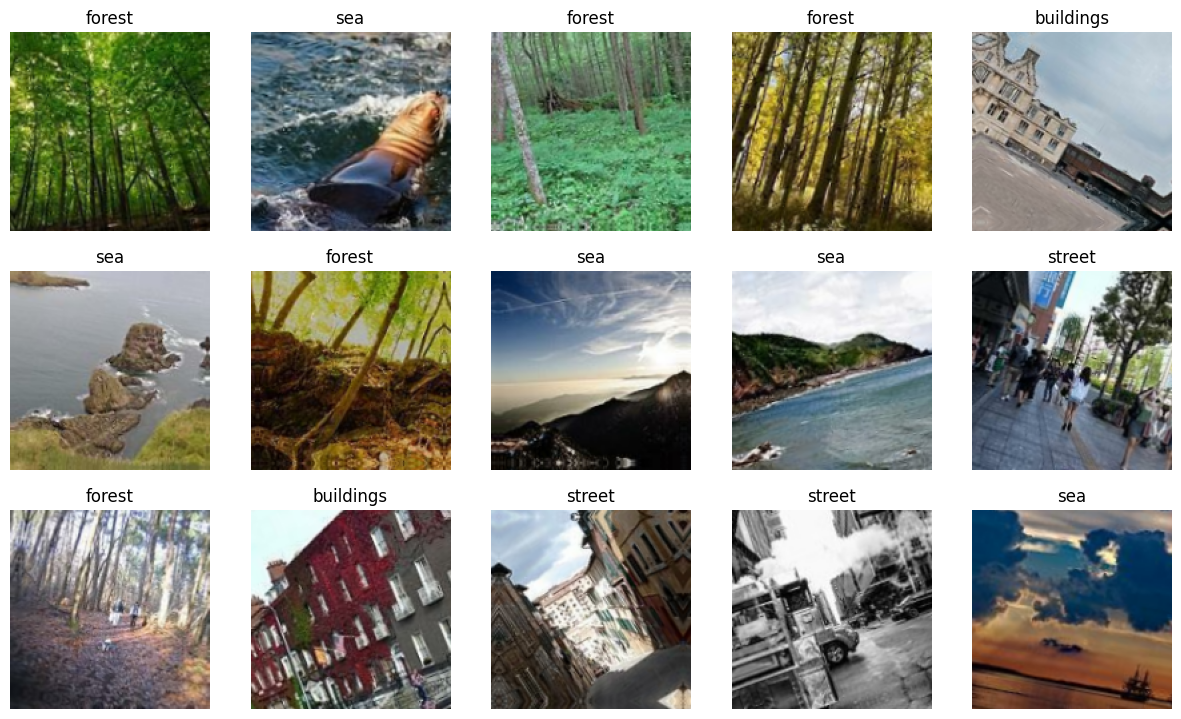

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(15):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

### Sampling of random images from dataset

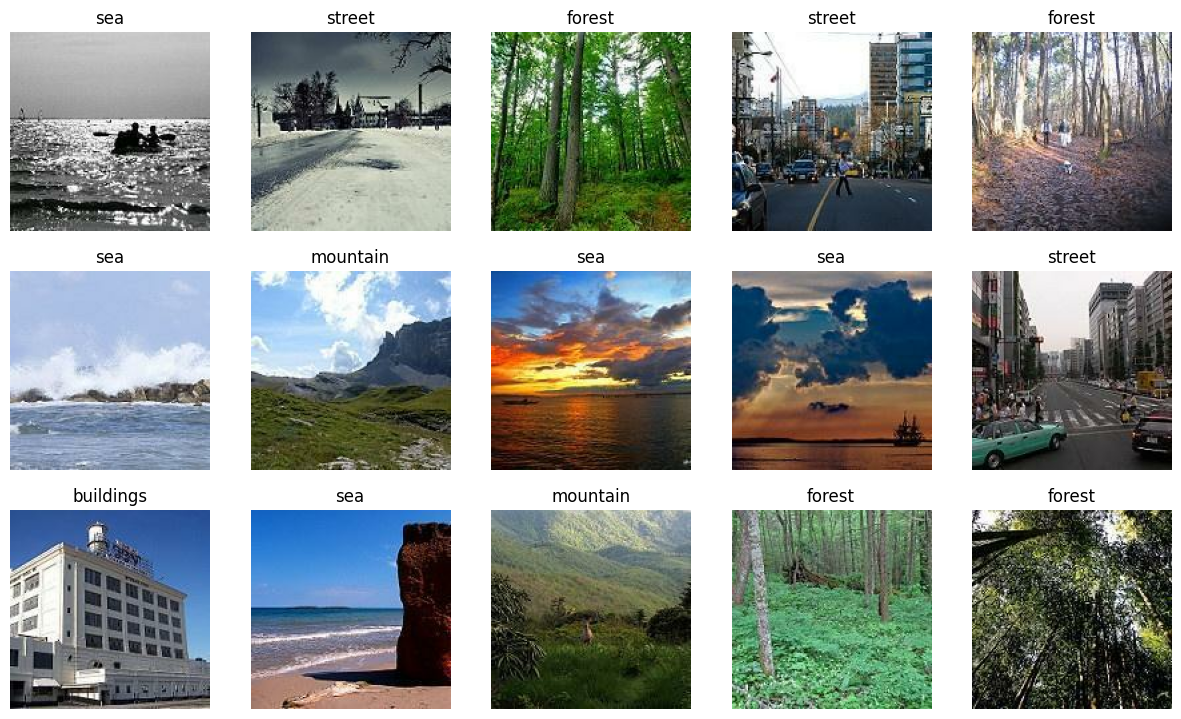

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

### Distribution Pie chart Plot

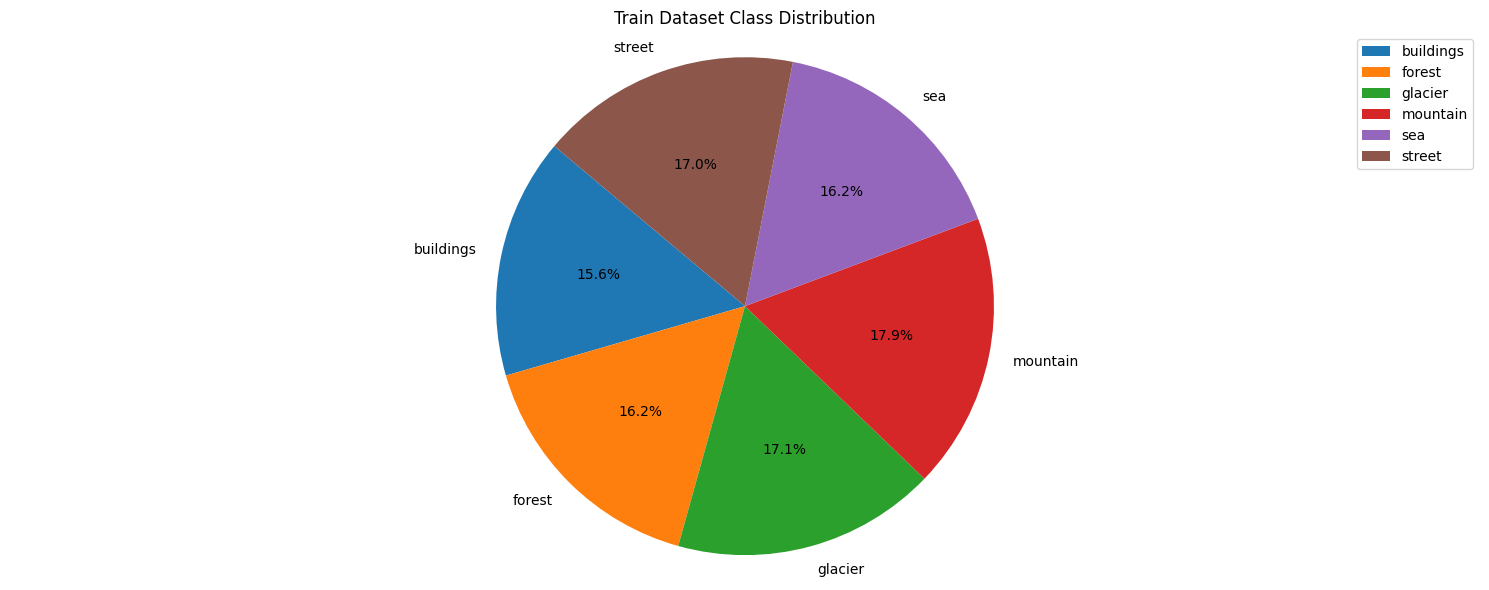

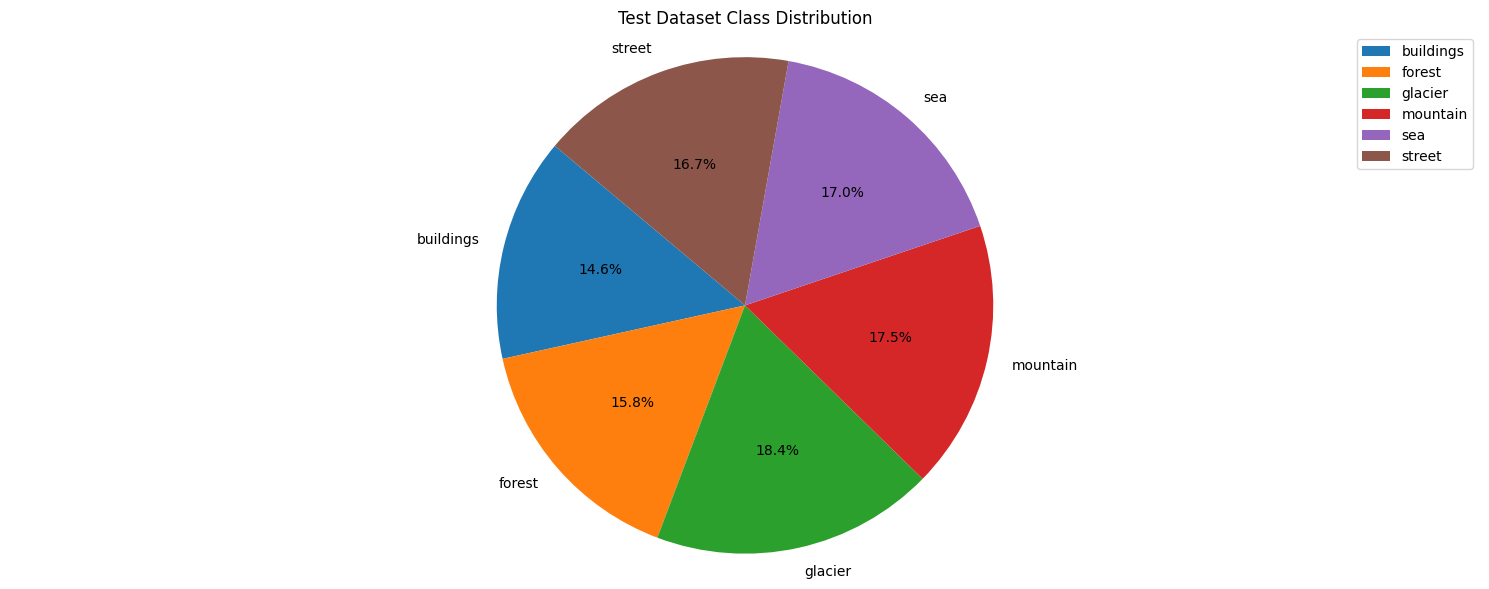

In [ ]:
for split in splits:
    # Pie chart
    labels = list(image_counts[split].keys())
    sizes = list(image_counts[split].values())

    plt.figure(figsize=(15, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"{split.capitalize()} Dataset Class Distribution")
    plt.axis('equal')  # Equal aspect ratio to make it a circle
    plt.tight_layout()
    plt.legend()
    plt.show()

### Count in bargraph

In [ ]:
def bargraph(count_ds):
    classes = list(count_ds['train'].keys())
    train_counts = [count_ds['train'][cls] for cls in classes]
    test_counts = [count_ds['test'][cls] for cls in classes]

    x = np.arange(len(classes))  # label locations
    width = 0.35  # width of the bars

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, train_counts, width, label='Train', color='steelblue')
    plt.bar(x + width/2, test_counts, width, label='Test', color='orange')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Train vs Test Dataset Class Distribution')
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

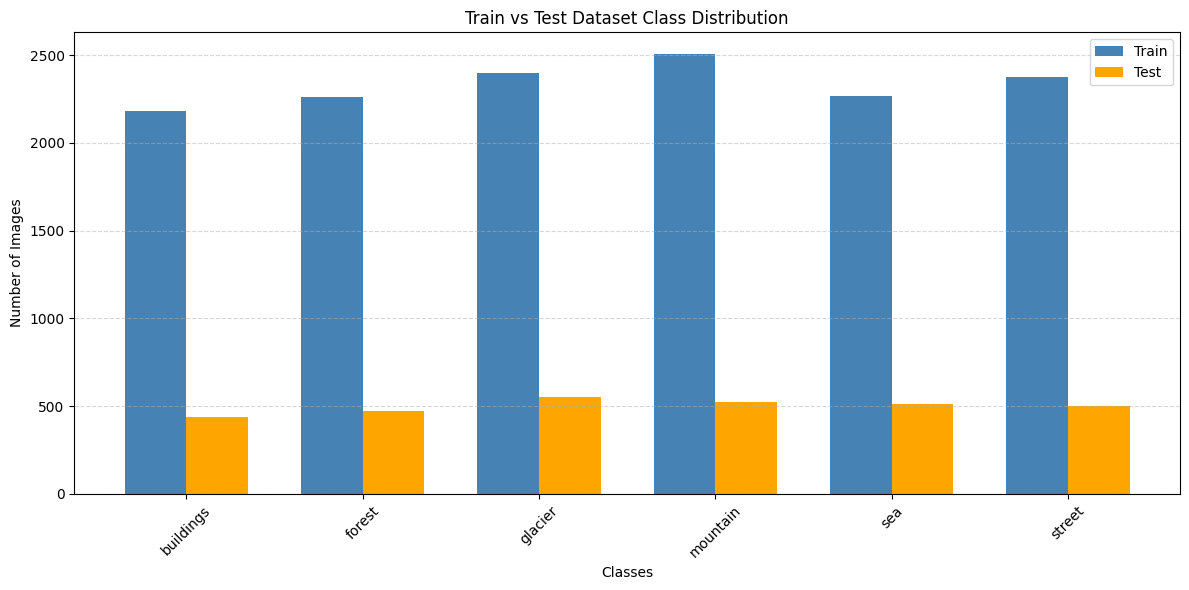

In [ ]:
bargraph(image_counts)

## QNA

### How many total images are in the dataset?

There were total of images is 17034 initally, but after cleaning out the corrupt images it split down to 16992 where all of the corrupted images were from the train directory.
Where,
    - Total number of images on Train Directory is 13992
    - Total number of images on Test Directory is 3000

### What is the distribution of images across different classes?

There are 6 classes in total where the images are distributed as:

**For Train**


| Class     | Number of Images |
|-----------|------------------|
| Buildings | 2184             |
| Forest    | 2264             |
| Glacier   | 2397             |
| Mountain  | 2505             |
| Sea       | 2267             |
| Street    | 2375             |


**For Test**

| Class     | Number of Images |
|-----------|------------------|
| Buildings | 437             |
| Forest    | 474             |
| Glacier   | 553             |
| Mountain  | 525             |
| Sea       | 510             |
| Street    | 501             |

### How is the dataset split into training and validation sets? Justify your choice.

The training dataset is loaded from the training directory where the dataset is loaded by using a util called image_dataset_from_directory from keras library. The right image size as provided which is 150*150 along with the image dataset into batches for 60 images per batch, shuffling the dataset with consistent randomness with seed and reserving 20% for validation test.

Whereas, the remaining (20% of the total size) is then selected from the dataset and used as the validation dataset.

### What preprocessing techniques (e.g., resizing, normalization) were applied?

The images are resized along with data augmentation so that all the images would be similar in the size and have more data to train the model.

### If data augmentation was applied, provide visualizations of sample augmented images.

The visualization can be seen in above section.

# Model Building

## Building a simple CNN model

In [ ]:
def simple_model(img_height, img_width, len_classes):
    """
    Improved CNN model with better architecture and regularization.

    Args:
        img_height (int): Height of input image.
        img_width (int): Width of input image.
        len_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    model = tf.keras.Sequential([

        # First Block of Convolution and Pooling Operations.
        # 32 filters, 3x3 kernel size, ReLU activation
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        # Max pooling layer with 2x2 pool size
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Second Block of Convolution and Pooling Operations.
        # 64 filters, 3x3 kernel size, ReLU activation
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max pooling layer with 2x2 pool size
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Third Block of Convolution and Pooling Operations (Optional, can be added for deeper model).
        # 128 filters, 3x3 kernel size, ReLU activation
        layers.Conv2D(128, (3, 3), activation='relu'),
        # Max pooling layer with 2x2 pool size
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Fully connected classifier.
        layers.Flatten(),  # Flatten the input to prepare for Dense layer
        # Fully connected layer with 128 units, ReLU activation
        layers.Dense(128, activation='relu'),
        # Output layer with units equal to the number of classes, Softmax for multi-class classification
        layers.Dense(len_classes, activation='softmax')
    ])

    return model

In [ ]:
model = simple_model(img_height, img_width, len(classes))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',   # Watch validation loss
    patience=3,           # Stop after 3 epochs with no improvement
    restore_best_weights=True  # Roll back to best weights
)

In [ ]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 101s 225ms/step - accuracy: 0.3543 - loss: 36.7067 - val_accuracy: 0.5100 - val_loss: 1.2418
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 223ms/step - accuracy: 0.5228 - loss: 1.2217 - val_accuracy: 0.5786 - val_loss: 1.0651
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 204ms/step - accuracy: 0.6223 - loss: 0.9796 - val_accuracy: 0.5636 - val_loss: 1.1879
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 228ms/step - accuracy: 0.6715 - loss: 0.8628 - val_accuracy: 0.6233 - val_loss: 1.0533
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 231ms/step - accuracy: 0.7419 - loss: 0.6734 - val_accuracy: 0.6126 - val_loss: 1.2551


## Validation loss  VS  Accuracy

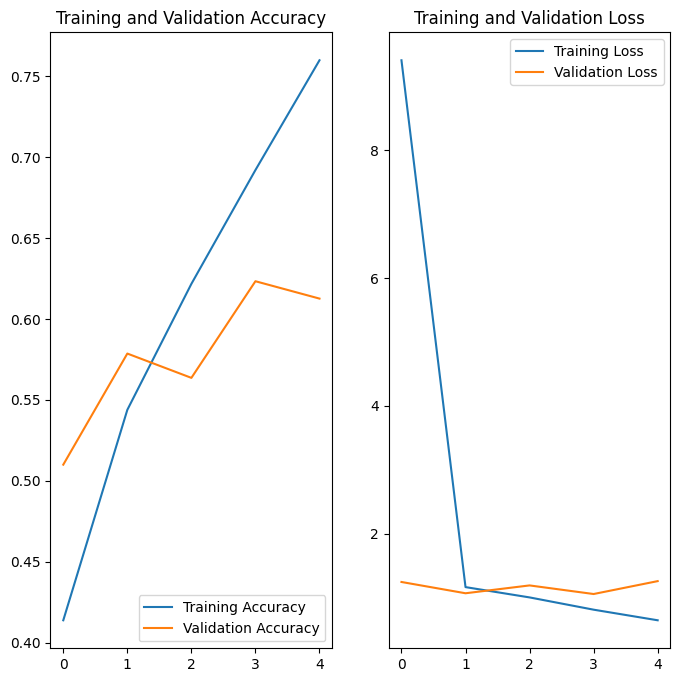

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.6178 - loss: 1.0527
Test Accuracy: 62.43%
Test Loss: 1.0224


In [ ]:
def evaluate_model_on_test(model, test_ds, class_names):
    # Collect all predictions and labels
    y_true = []
    y_pred = []

    for batch_images, batch_labels in test_ds:
        preds = model.predict(batch_images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(batch_labels.numpy())

    # Accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


def visualize_predictions(model, test_ds, class_names, num_images=5):
    plt.figure(figsize=(15, 4))
    test_images, test_labels = next(iter(test_ds.take(1)))

    for i in range(num_images):
        img = test_images[i]
        label = test_labels[i].numpy()
        pred = model.predict(tf.expand_dims(img, 0), verbose=0)
        pred_label = np.argmax(pred)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(
            f"Pred: {class_names[pred_label]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Test Accuracy: 0.6243

Classification Report:

              precision    recall  f1-score   support

   buildings       0.55      0.62      0.58       437
      forest       0.85      0.84      0.84       474
     glacier       0.53      0.57      0.55       553
    mountain       0.59      0.63      0.61       525
         sea       0.53      0.37      0.43       510
      street       0.70      0.75      0.72       501

    accuracy                           0.62      3000
   macro avg       0.62      0.63      0.62      3000
weighted avg       0.62      0.62      0.62      3000



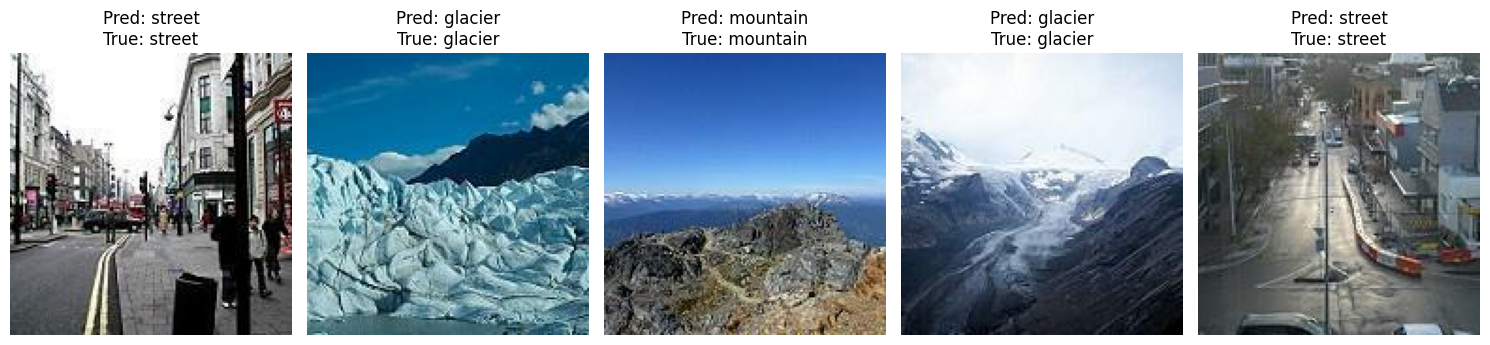

In [ ]:
# Run evaluation on whole dataset
evaluate_model_on_test(model, test_ds, classes)

# Optionally visualize a few predictions
visualize_predictions(model, test_ds, classes)

The above built model's performance while training the model and validating on the validation data on 5 epochs shows that the training accuracy increased exponentially from 0.50 to 0.827 where the training loss has also exponentially decreased but on the validation data the model performance peaked on 0.67 accuracy and validation loss being around 1 consistently on all the epochs.

On test data, the accuracy of the model was 0.6423, with the precision being 0.65 with recall of 0.64 and the f1-score of 0.64.

# Deeper Architecture with Regularization Layer

## Extending Model Architecture

In [ ]:
def deeper_model(img_height, img_width, len_classes):
    """
    Deeper CNN model with increased filters, layers, and regularization.

    Args:
        img_height (int): Height of input image.
        img_width (int): Width of input image.
        len_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    model = tf.keras.Sequential([
        # Input layer
        layers.InputLayer(input_shape=(img_height, img_width, 3)),

        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        # Flatten and FC layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(len_classes, activation='softmax')
    ])

    return model

In [ ]:
deeper_model = deeper_model(img_height, img_width, len(classes))

deeper_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 720000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │   184,320,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,415,686 (703.49 MB)

 Trainable params: 184,415,366 (703.49 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
deeper_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#deeper_model_history = deeper_model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs,
#   callbacks=[early_stop]
# )

Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 52s 248ms/step - accuracy: 0.3594 - loss: 9.6187 - val_accuracy: 0.4707 - val_loss: 1.4163
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 232ms/step - accuracy: 0.4307 - loss: 1.3456 - val_accuracy: 0.5493 - val_loss: 1.2845
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 84s 243ms/step - accuracy: 0.4858 - loss: 1.2462 - val_accuracy: 0.5747 - val_loss: 1.1014
Epoch 4/5
 35/187 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.5080 - loss: 1.1789